## Importaciones

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
import math

from statsmodels.tsa.seasonal import seasonal_decompose #descomposición de una serie temporal
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

from ipywidgets import interact
import plotly.express as px
import ipywidgets as widgets

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sodapy import Socrata

### Definición de funciones


In [2]:
#Definición de funciones

#Formula para evaluar modelos:
def get_error_percentage(real_it, predicted_it):
    #cuanto más cerca del 0 mejor
    print("get_error_percentage() method was called.")
    rmse = math.sqrt(mean_squared_error(real_it, 
    predicted_it))
    error_percentage = rmse / np.average(real_it)
    return error_percentage

In [3]:
def analisis_adfuller(ts):
    if adfuller(ts)[1]>0.05:
        return f'Rechazamos la Ho porque {adfuller(ts)[1]} es mayor que 0.05. Por tanto, la señal es estacionaria'
    else:
        return f'La señal no es estacionaria'

### Dataset

In [4]:
df = pd.read_csv('output/Enfer.csv', sep=',',encoding='latin1',decimal=".")

In [5]:
#comprobamos los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    230 non-null    int64  
 1   COLECTIVO                230 non-null    object 
 2   mes                      230 non-null    int64  
 3   año                      230 non-null    int64  
 4   Festivos_intersemanales  230 non-null    int64  
 5   Plantilla                230 non-null    float64
 6   Plantilla_de_baja        230 non-null    float64
 7   date                     230 non-null    object 
 8   casos_covid              230 non-null    float64
 9   busquedas_google         230 non-null    float64
 10  cambio_normativa         230 non-null    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 19.9+ KB


In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
#Elimino columnas no relevantes para análisis de series temporales
df.drop(['index','COLECTIVO','mes','año'],axis=1,inplace=True)

## Feature selection

In [8]:
#definimos X e y:
X=df.drop(['Plantilla_de_baja','date'],axis=1)
y=df['Plantilla_de_baja']

In [9]:
#seleccion de columnas a partir de modelo
sel = SelectFromModel(RandomForestRegressor(n_estimators = 1000))
sel.fit(X,y)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=1000))

In [10]:
X.columns[(sel.get_support())]

Index(['Plantilla', 'casos_covid'], dtype='object')

El feature selection form model de Random Forest sugiere sólo considerar las variables 'Plantilla' y 'Casos_covid'

## Análisis de series temporales

### Visualizacion componentes de seasonal descompose

In [11]:
ts=df.set_index('date')
ts_it=ts[['Plantilla_de_baja']]
ts_covid=ts[['casos_covid']][-24:] #desde marzo 2020
ts_plantilla=ts[['Plantilla']]
ts_google=ts[['busquedas_google']][32:] #desde octubre de 2005

'Rechazamos la Ho porque 0.06440568637511643 es mayor que 0.05. Por tanto, la señal es estacionaria'

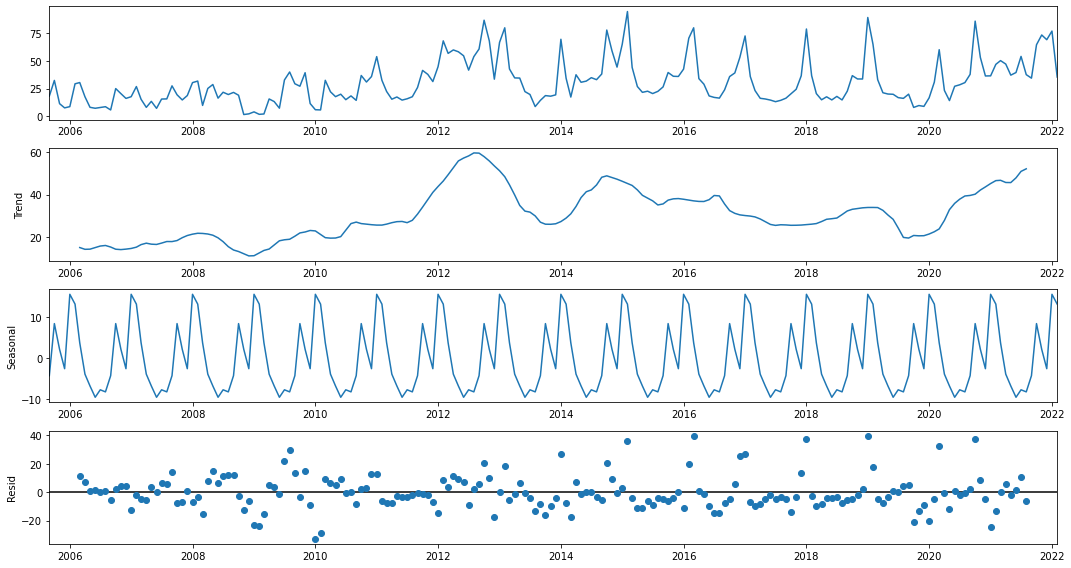

In [12]:
#Analizamos estacionalidad de busquedas en google
plt.rcParams['figure.figsize']=(15,8)

decomposition=seasonal_decompose(ts_google)
_=decomposition.plot()

analisis_adfuller(ts_google)


'Rechazamos la Ho porque 0.17845548292375096 es mayor que 0.05. Por tanto, la señal es estacionaria'

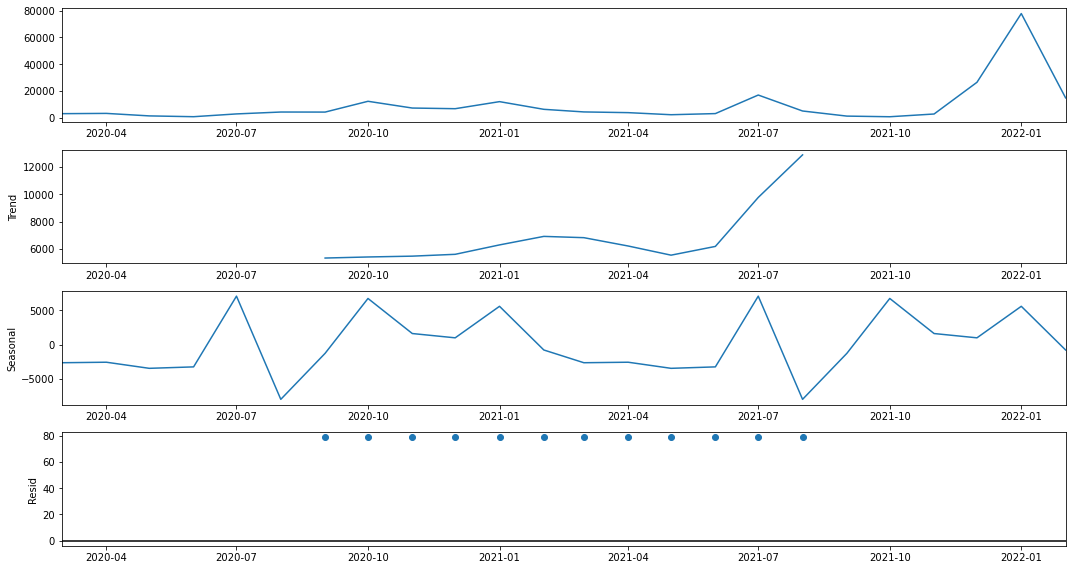

In [13]:
#Analizamos estacionalidad de casos covid
decomposition=seasonal_decompose(ts_covid)
_=decomposition.plot()

analisis_adfuller(ts_covid)

'Rechazamos la Ho porque 0.9765228601891162 es mayor que 0.05. Por tanto, la señal es estacionaria'

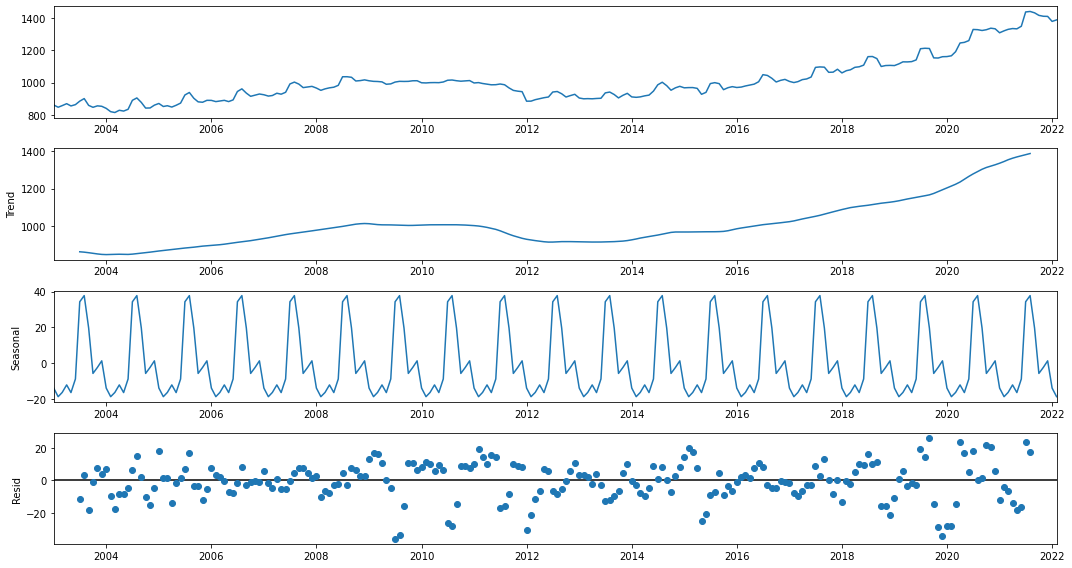

In [14]:
#Analizamos estacionalidad de busquedas en plantilla
decomposition=seasonal_decompose(ts_plantilla)
_=decomposition.plot()

analisis_adfuller(ts_plantilla)

'Rechazamos la Ho porque 0.26546786156435415 es mayor que 0.05. Por tanto, la señal es estacionaria'

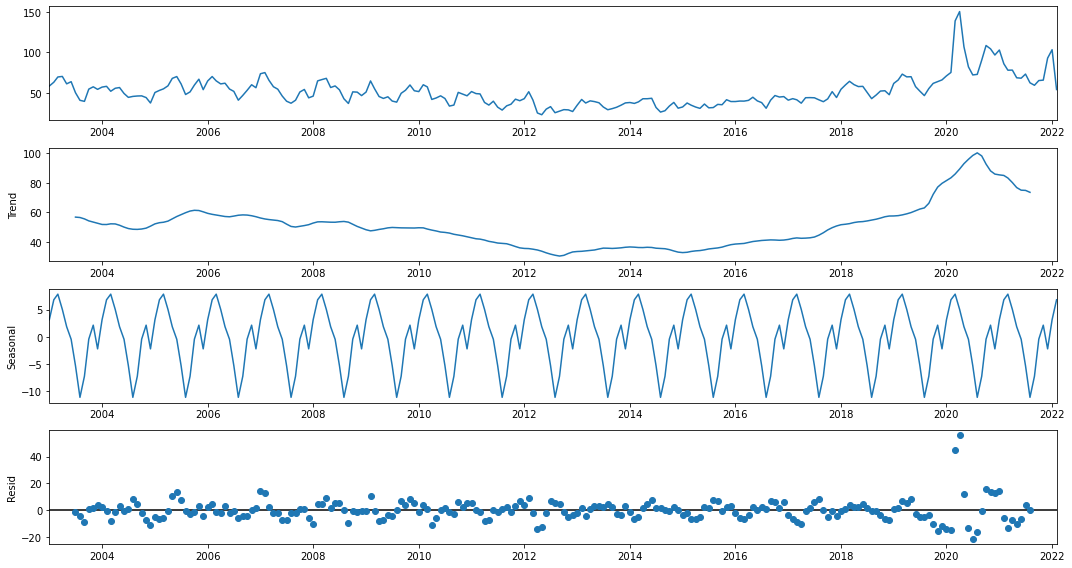

In [15]:
#Analizamos estacionalidad de busquedas en plantilla de it
decomposition=seasonal_decompose(ts_it)
_=decomposition.plot()

analisis_adfuller(ts_it)

### Funciones ACF/PACF

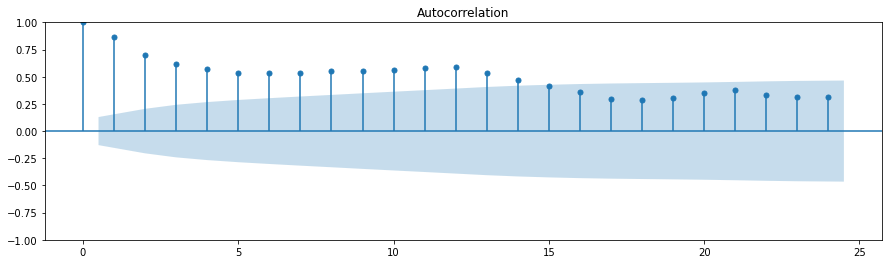

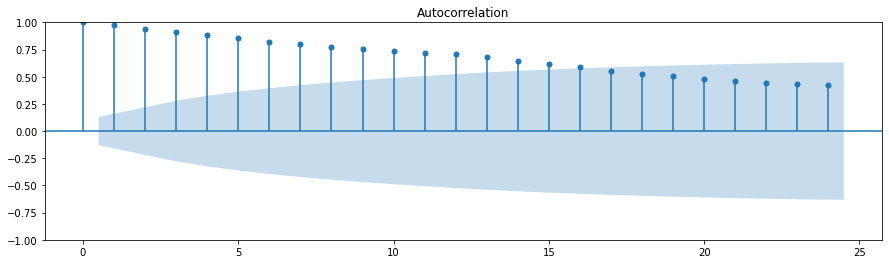

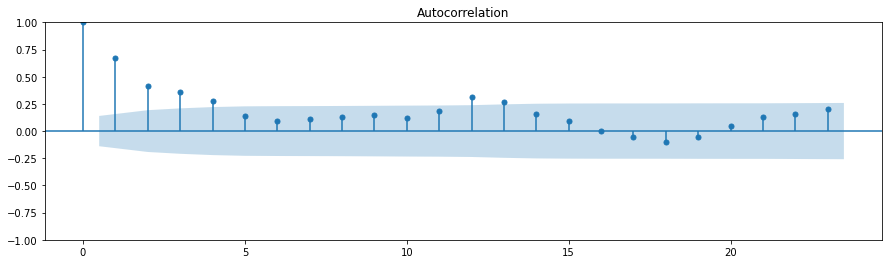

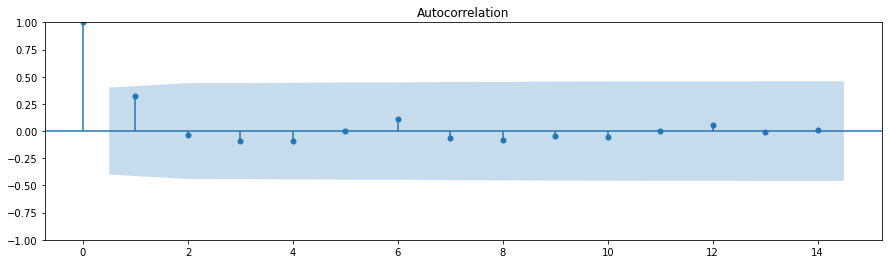

In [16]:
plt.rcParams['figure.figsize']=(15,4)
for i in [ts_it,ts_plantilla,ts_google,ts_covid]:
    _=plot_acf(i)

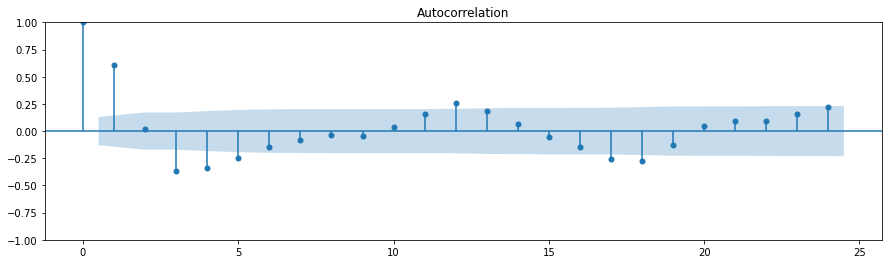

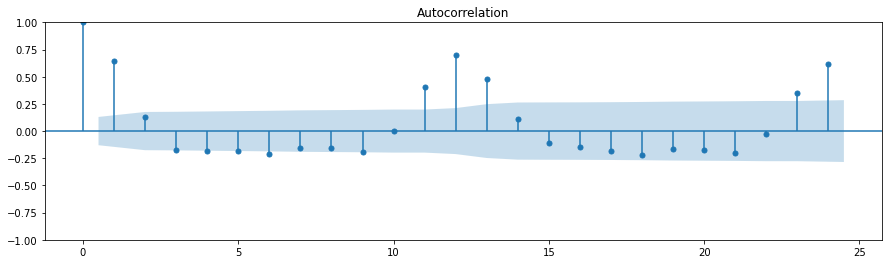

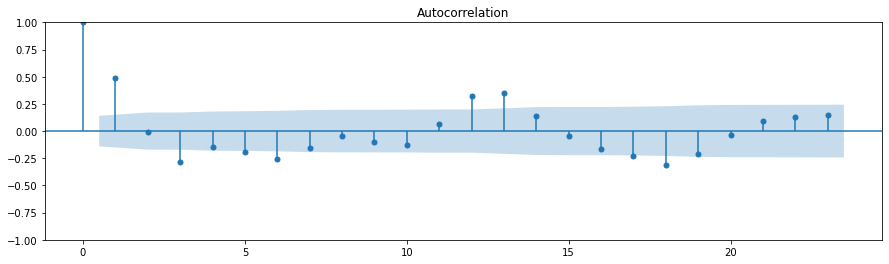

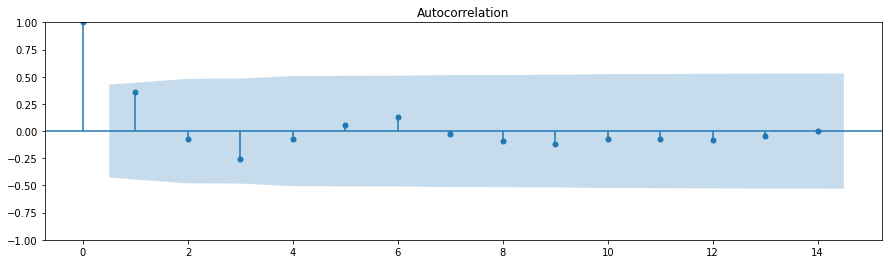

In [17]:
#diferenciación de 3 para ver más clara la estacionalidad
plt.rcParams['figure.figsize']=(15,4)
for i in [ts_it,ts_plantilla,ts_google,ts_covid]:
    _=plot_acf(i.diff(3).dropna())

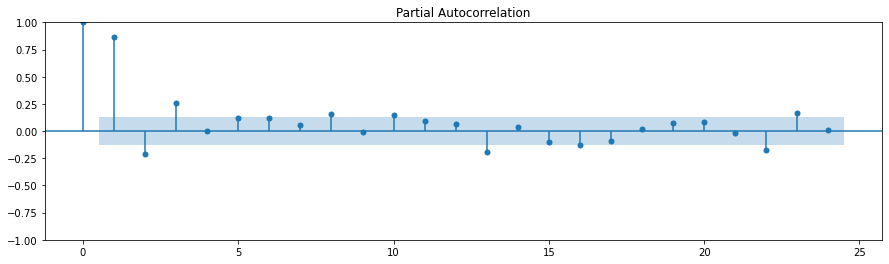

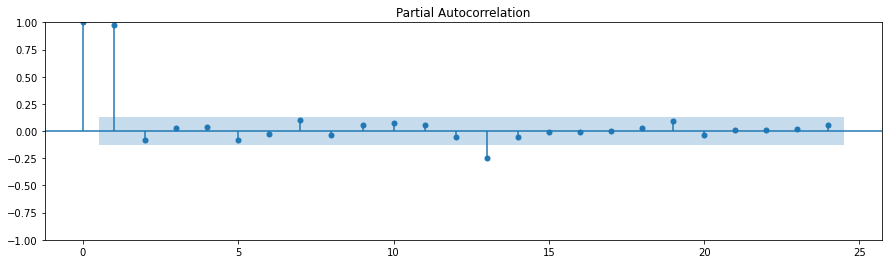

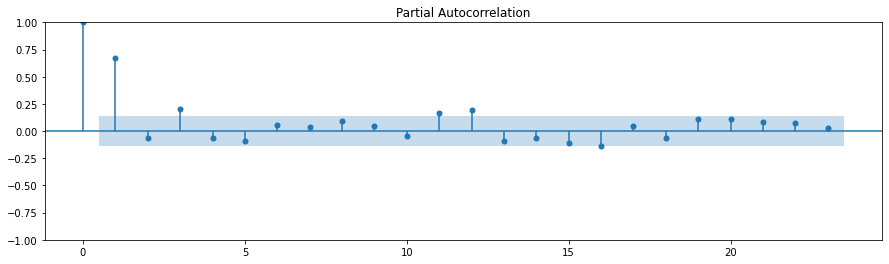

In [19]:
plt.rcParams['figure.figsize']=(15,4) #No se puede con ts_covid pq no hay suficientes muestras
for i in [ts_it,ts_plantilla,ts_google]:
    _=plot_pacf(i, method='ywm')

### Conclusiones
* Se observa estacionaridad de 12 meses de la variable plantilla de it.
* Se observa estacionaridad de 12 meses de la variable plantilla.
* Se observa estacionaridad de 12 meses de la variable búsquedas google.
* No se observa estacionaridad en la variable casos covid

## Selección de modelo

### Modelos sin variables exógenas

#### Autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1628.428, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.526, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.579, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.325, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.527, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1627.818, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1642.732, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.682, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1626.931, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.115, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1627.060, Time=0.13 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1620.536, Time=0.29 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1620.577, Time=0.28 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1619.387, Time=0.44 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 5, 12) y un porcentaje de error del 0.1565102310814885'

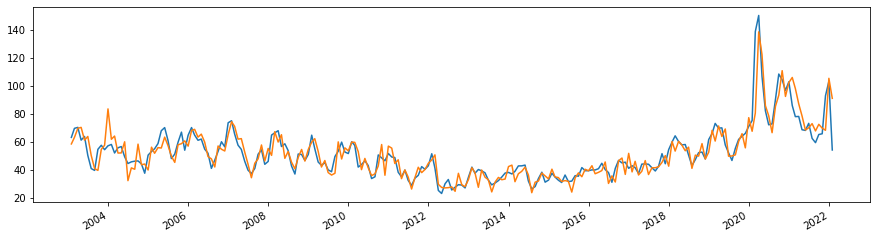

In [20]:
#Obtener mejor modelo de Arima
model1=auto_arima(ts_it, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model1.order 
sparams = model1.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel1 = SARIMAX(ts_it, 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results1=smodel1.fit(maxiter=1000)

#hacemos una prediccion de todos los datos a partir de nuestro modelo
plt.plot(ts_it[1:])
y_pred_SAR1=results1.get_prediction(start='2003-02-01',end='2022-02-01').predicted_mean
y_pred_SAR1.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX=get_error_percentage(ts_it[1:],y_pred_SAR1)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX}'

In [21]:
#Clasificamos modelo
ranking_modelos=[]
tuple=('smodel1','Sarimax sin exógenos',porc_error_SARIMAX,sparams)
ranking_modelos.append(tuple)

#### FbProphet

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.20320581873578303'

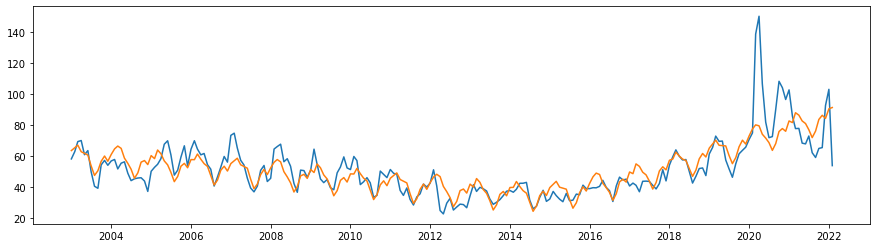

In [22]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model2=Prophet() 
#transformación requerida
prf=ts_it.reset_index().rename(columns={'date':'ds','Plantilla_de_baja':'y'}) 
#entrenamos modelo
model2.fit(prf)
#obtenemos valores de predicciones
yhat=model2.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts_it)
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts_it,y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'

In [23]:
#Clasificamos modelo
tuple=('model2','Prophet sin exógenos',porc_error_PROPHET,'')
ranking_modelos.append(tuple)

### Modelos con variables exógenas

#### Autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1628.428, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.526, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.579, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.325, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.527, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1627.818, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1642.732, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.682, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1626.931, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.115, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1627.060, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1620.536, Time=0.28 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1620.577, Time=0.28 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1619.387, Time=0.44 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 5, 12) y un porcentaje de error del 0.15155244370444557'

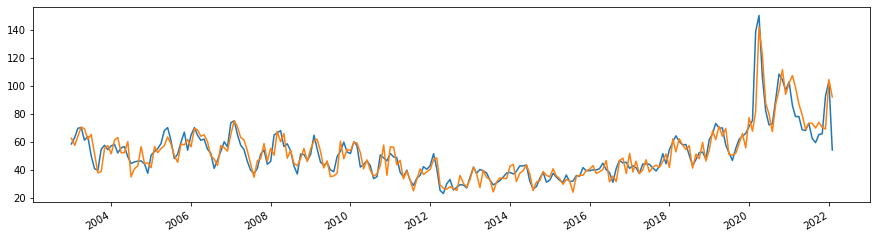

In [24]:
#Obtener mejor modelo de Arima
#Usamos como variables exógenas las sugeridas por random forest (No incluimos casos_covid porque no se puede predecir con time series)
exogenas=ts[['Plantilla']]
model3=auto_arima(ts[['Plantilla_de_baja']],exog=exogenas, trace=True)
model3=auto_arima(ts[['Plantilla_de_baja']], trace=True)
#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model3.order 
sparams = model3.order+(12,) 
#freq MS quiere decir frecuencia mensual

smodel3 = SARIMAX(ts[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

results3=smodel3.fit(maxiter=1000)

#intentamos hacer una prediccion de los datos  a partir de nuestro modelo
plt.plot(ts['Plantilla_de_baja'])
y_pred_SAR3=results3.get_prediction(start='2003-01-01',end='2022-02-01').predicted_mean
y_pred_SAR3.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX2=get_error_percentage(ts_it['Plantilla_de_baja'],y_pred_SAR3)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX2}'


In [25]:
#Clasificamos modelo
tuple=('smodel3','Sarimax con exógeno plantilla',porc_error_SARIMAX2,sparams)
ranking_modelos.append(tuple)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1628.428, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.526, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.579, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.325, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.527, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1627.818, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1642.732, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.682, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1626.931, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.115, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1627.060, Time=0.13 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1620.536, Time=0.30 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1620.577, Time=0.29 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1619.387, Time=0.44 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 5, 12) y un porcentaje de error del 0.14194791072228088'

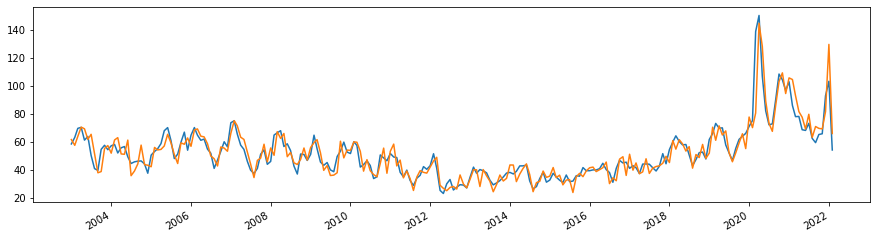

In [26]:
#Obtener mejor modelo de Arima
#Usamos como  variables exógenas todas las sugeridas por random forest 
exogenas=ts[['Plantilla','casos_covid']]
model3b=auto_arima(ts[['Plantilla_de_baja']],exog=exogenas, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model3b.order 
sparams = model3b.order+(12,) 
#freq MS quiere decir frecuencia mensual

smodel3b = SARIMAX(ts[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

results3=smodel3b.fit(maxiter=1000)

#intentamos hacer una prediccion de los datos  a partir de nuestro modelo
plt.plot(ts['Plantilla_de_baja'])
y_pred_SAR3b=results3.get_prediction(start='2003-01-01',end='2022-02-01').predicted_mean
y_pred_SAR3b.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX2b=get_error_percentage(ts_it['Plantilla_de_baja'],y_pred_SAR3b)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX2b}'


In [27]:
#Clasificamos modelo
tuple=('smodel3b','Sarimax con exógeno plantilla y casos_covid',porc_error_SARIMAX2b,sparams)
ranking_modelos.append(tuple)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1628.428, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.526, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.579, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.325, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.527, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1627.818, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1642.732, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.682, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1626.931, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.115, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1627.060, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1620.536, Time=0.29 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1620.577, Time=0.29 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1619.387, Time=0.42 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 5, 12) y un porcentaje de error del 0.1465898246657809'

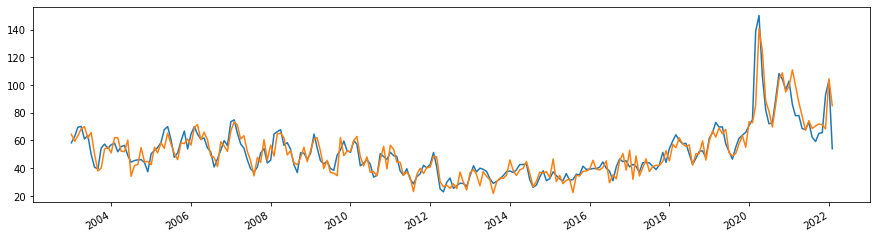

In [28]:
#Obtener mejor modelo de Arima 
#Usamos como variables exógenas todas las variables con no son la objetivo ni casos covid (pq no se puede predecir con time series)
exogenas=ts.drop(['Plantilla_de_baja','casos_covid'],axis=1)
model4=auto_arima(ts[['Plantilla_de_baja']],exog=exogenas, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model4.order 
sparams = model4.order+(12,) 
#freq MS quiere decir frecuencia mensual

smodel4 = SARIMAX(ts[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

results4=smodel4.fit(maxiter=1000)

#intentamos hacer una prediccion de los datos  a partir de nuestro modelo
plt.plot(ts['Plantilla_de_baja'])
y_pred_SAR4=results4.get_prediction(start='2003-01-01',end='2022-02-01').predicted_mean
y_pred_SAR4.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX3=get_error_percentage(ts_it['Plantilla_de_baja'],y_pred_SAR4)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX3}'

In [29]:
#Clasificamos modelo
tuple=('smodel4','Sarimax con todos los exógenos (menos casos_covid)',porc_error_SARIMAX3,sparams)
ranking_modelos.append(tuple)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1628.428, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.526, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.579, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.325, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.527, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1627.818, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1642.732, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.682, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1626.931, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.115, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1627.060, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1620.536, Time=0.28 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1620.577, Time=0.28 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1619.387, Time=0.42 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 5, 12) y un porcentaje de error del 0.1465898246657809'

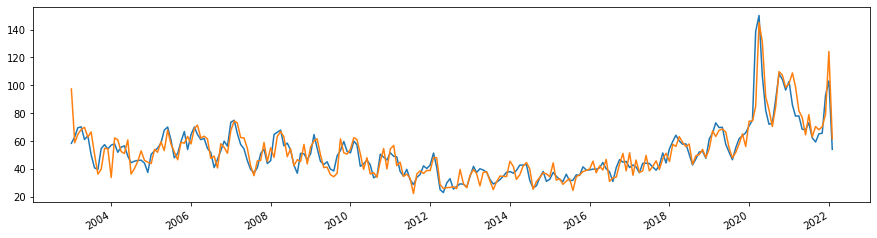

In [30]:
#Obtener mejor modelo de Arima 
#Usamos como variables exógenas todas las variables con no son la objetivo
exogenas=ts.drop(['Plantilla_de_baja'],axis=1)
model5=auto_arima(ts[['Plantilla_de_baja']],exog=exogenas, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model5.order 
sparams = model5.order+(12,) 
#freq MS quiere decir frecuencia mensual

smodel5 = SARIMAX(ts[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

results5=smodel5.fit(maxiter=1000)

#intentamos hacer una prediccion de los datos  a partir de nuestro modelo
plt.plot(ts['Plantilla_de_baja'])
y_pred_SAR5=results5.get_prediction(start='2003-01-01',end='2022-02-01').predicted_mean
y_pred_SAR5.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX4=get_error_percentage(ts_it['Plantilla_de_baja'],y_pred_SAR5)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX3}'

In [31]:
#Clasificamos modelo
tuple=('smodel5','Sarimax con todos los exógenos',porc_error_SARIMAX4,sparams)
ranking_modelos.append(tuple)

#### FbProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.20191739288030539'

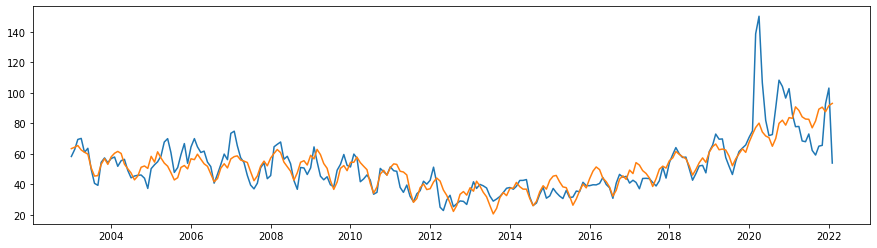

In [32]:
# Obtener modelo con Fbprophet usando variables exógenas recomendadas por Random Forest (salvo covid)
#instanciamos prophet
model5=Prophet() 
#transformación requerida
prf=ts.reset_index().rename(columns={'date':'ds','Plantilla_de_baja':'y'}) 
#anadimos la exógena
model5.add_regressor('Plantilla')
#model5.add_regressor('casos_covid')
#entrenamos modelo
model5.fit(prf)
#obtenemos valores de predicciones
yhat=model5.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts['Plantilla_de_baja'])
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET2=get_error_percentage(ts['Plantilla_de_baja'],y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET2}'

In [33]:
#Clasificamos modelo
tuple=('model5','Prophet con exógeno plantilla',porc_error_PROPHET2,'')
ranking_modelos.append(tuple)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.19842068544437377'

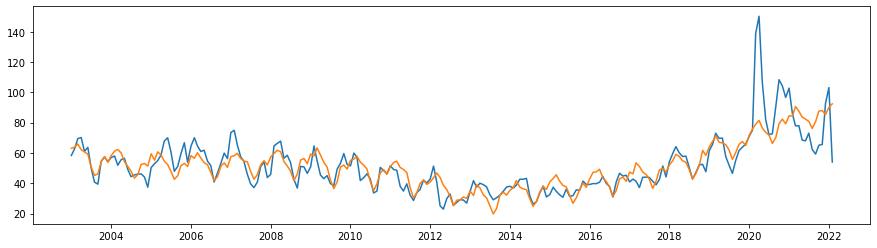

In [34]:
# Obtener modelo con Fbprophet usando todas las variables exógenas (salvo COVID)
#instanciamos prophet
model6=Prophet() 
#transformación requerida
prf=ts.reset_index().rename(columns={'date':'ds','Plantilla_de_baja':'y'}) 
#anadimos la exógena
model6.add_regressor('Plantilla')
#model6.add_regressor('casos_covid')
model6.add_regressor('Festivos_intersemanales')
model6.add_regressor('busquedas_google')
model6.add_regressor('cambio_normativa')
#entrenamos modelo
model6.fit(prf)
#obtenemos valores de predicciones
yhat=model6.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts['Plantilla_de_baja'])
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET3=get_error_percentage(ts['Plantilla_de_baja'],y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET3}'

In [35]:
#Clasificamos modelo
tuple=('model6','Prophet con todos los exógenos (menos COVID)',porc_error_PROPHET3,'')
ranking_modelos.append(tuple)

### Conclusiones

In [36]:
ranking=pd.DataFrame(ranking_modelos, columns =['Modelo', 'Descripción', 'Score','Sparams']).sort_values(by='Score')
ranking

,Modelo,Descripción,Score,Sparams
3,smodel3b,Sarimax con exógeno plantilla y casos_covid,0.141948,"(1, 1, 5, 12)"
4,smodel4,Sarimax con todos los exógenos (menos casos_co...,0.146590,"(1, 1, 5, 12)"
2,smodel3,Sarimax con exógeno plantilla,0.151552,"(1, 1, 5, 12)"
5,smodel5,Sarimax con todos los exógenos,0.151991,"(1, 1, 5, 12)"
0,smodel1,Sarimax sin exógenos,0.156510,"(1, 1, 5, 12)"
7,model6,Prophet con todos los exógenos (menos COVID),0.198421,
6,model5,Prophet con exógeno plantilla,0.201917,
1,model2,Prophet sin exógenos,0.203206,


In [37]:
print(f'El primer mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de {smodel3b.exog_names} y parámetros {smodel3b.seasonal_order}')
print(f'El segundo mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de {smodel5.exog_names} y parámetros {smodel5.seasonal_order}')
print(f'El tercer mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de {smodel4.exog_names} y parámetros {smodel4.seasonal_order}')

El primer mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de ['Plantilla', 'casos_covid'] y parámetros (1, 1, 5, 12)
El segundo mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de ['Festivos_intersemanales', 'Plantilla', 'casos_covid', 'busquedas_google', 'cambio_normativa'] y parámetros (1, 1, 5, 12)
El tercer mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de ['Festivos_intersemanales', 'Plantilla', 'busquedas_google', 'cambio_normativa'] y parámetros (1, 1, 5, 12)


## Modelos para predecir variables exógenas

### Plantilla

#### Autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1947.831, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2022.811, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2016.891, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2011.334, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2023.875, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2002.987, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2002.063, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1948.328, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1948.322, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2011.583, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1993.125, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2002.293, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1949.879, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1949.340, Time=0.32 sec

Best model:  ARIMA(2,1,2)(0,0,0)

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (2, 1, 2, 12) y un porcentaje de error del 0.031191681757506404'

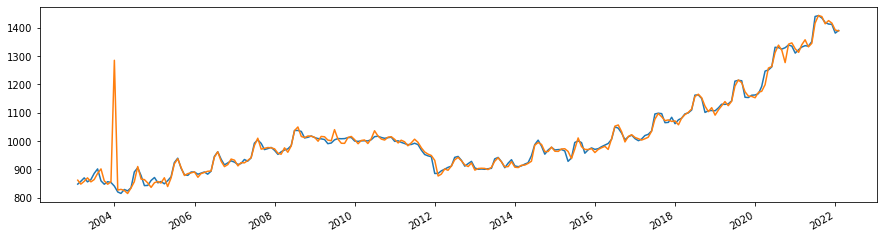

In [38]:
#Obtener mejor modelo de Arima
model7=auto_arima(ts[['Plantilla']], trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model7.order 
sparams = model7.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel7 = SARIMAX(ts[['Plantilla']], 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results7=smodel7.fit(maxiter=1000)

#hacemos una prediccion de todos los datos a partir de nuestro modelo
plt.plot(ts[['Plantilla']][1:])
y_pred_model7=results7.get_prediction(start='2003-02-01',end='2022-02-01').predicted_mean
y_pred_model7.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX=get_error_percentage(ts[['Plantilla']][1:],y_pred_model7)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX}'

#### FbProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.01707449110200554'

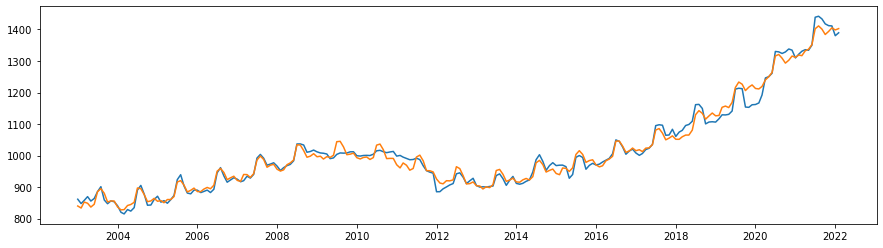

In [39]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model8=Prophet() 
#transformación requerida
prf=ts[['Plantilla']].reset_index().rename(columns={'date':'ds','Plantilla':'y'}) 
#entrenamos modelo
model8.fit(prf)
#obtenemos valores de predicciones
yhat=model8.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts[['Plantilla']])
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts[['Plantilla']],y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'

### Casos_covid

In [40]:
#Importamos dataset casos covid
df_covid = pd.read_csv('data/casos_covid.csv', sep=',',encoding='latin1')

In [41]:
#transformación
df_covid['date']=df_covid.date.astype('datetime64[ns]')


#### Arima

In [42]:
ts_covid=df_covid.set_index('date')

In [43]:
#Obtener mejor modelo de Arima
model9=auto_arima(ts_covid, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=556.534, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=555.904, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=555.236, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=562.103, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=557.206, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=558.042, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=559.612, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=557.945, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.315 seconds


<AxesSubplot:>

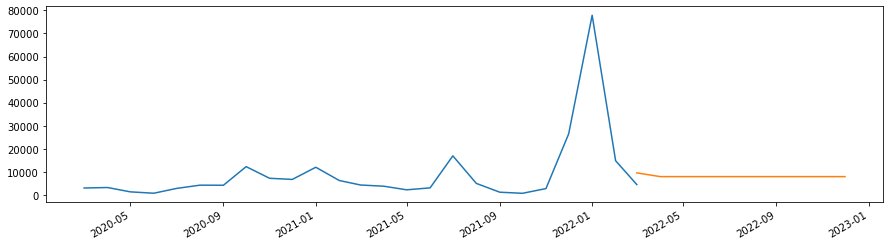

In [44]:
#creamos una serie para darle un indice
pred=model9.predict(n_periods=10)
plt.plot(ts_covid)
pd.Series(pred, index=pd.date_range(start='2022-03-01', end='2022-12-01', freq='MS')).plot()

#### FbProphet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.0'

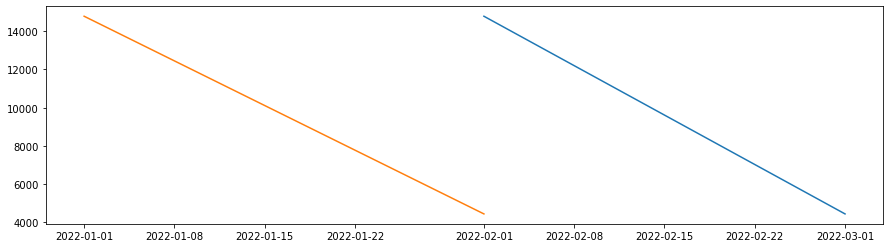

In [45]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model9=Prophet(growth='linear') 
#transformación requerida
prf=ts_covid[-2:].reset_index().rename(columns={'date':'ds','numcasos':'y'})
#prf['cap']=78000
#entrenamos modelo
model9.fit(prf)
#obtenemos valores de predicciones
yhat=model9.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2022-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts_covid[-2:])
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts_covid[-2:],y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'


In [46]:
ds= pd.DataFrame({'ds':pd.date_range(start='2022-03-01',
                                  end='2022-12-01',
                                  freq='MS')})

In [47]:
model9.predict(ds).yhat

0     4440.000000
1    -7012.285714
2   -18095.142857
3   -29547.428571
4   -40630.285714
5   -52082.571429
6   -63534.857143
7   -74617.714286
8   -86070.000000
9   -97152.857143
Name: yhat, dtype: float64

In [48]:
#Conclusión => con los métodos que conocemos no es posible predicir la evolución de los datos covid

### Búsquedas Google

In [49]:
ts_google=ts[['busquedas_google']][32:] #desde septiembre de 2005

#### Autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1624.148, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1658.553, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1658.105, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1653.519, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1656.559, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1623.108, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1626.401, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1624.384, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1637.717, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1622.312, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1624.992, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1625.8

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 2, 12) y un porcentaje de error del 0.45383229465014374'

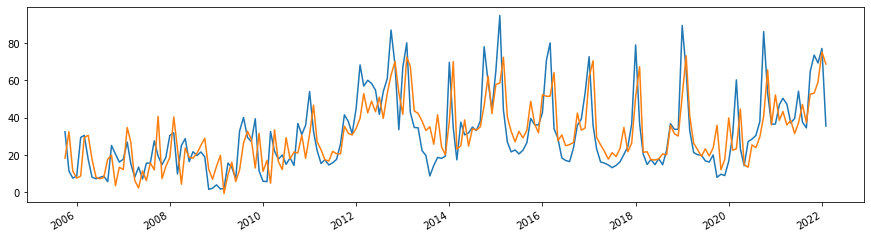

In [50]:
#Obtener mejor modelo de Arima
model10=auto_arima(ts_google, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model10.order 
sparams = model10.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel10 = SARIMAX(ts_google, 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results10=smodel10.fit(maxiter=1000)

#hacemos una prediccion de todos los datos a partir de nuestro modelo
plt.plot(ts_google[1:])
y_pred_model10=results10.get_prediction(start='2005-10-01',end='2022-02-01').predicted_mean
y_pred_model10.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX=get_error_percentage(ts_google[1:],y_pred_model10)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX}'

#### FbProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.539048243090492'

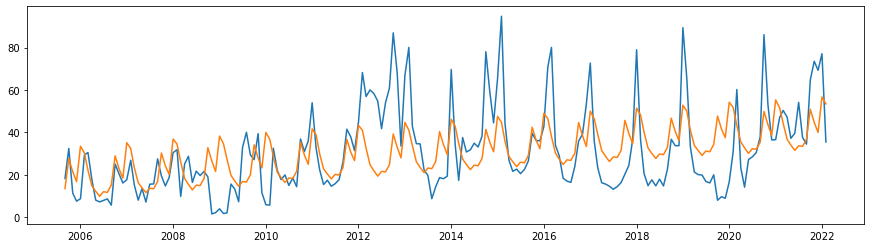

In [51]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model11=Prophet() 
#transformación requerida
prf=ts_google.reset_index().rename(columns={'date':'ds','busquedas_google':'y'}) 
#entrenamos modelo
model11.fit(prf)
#obtenemos valores de predicciones
yhat=model11.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2005-09-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts_google)
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts_google,y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'

## Modelos predictivos sin contar con meses COVID

In [52]:
ts_sin_COVID=ts.reset_index()
ts_sin_COVID=ts_sin_COVID[ts_sin_COVID['date']<'2020-03-01'].set_index('date').drop('casos_covid',axis=1)

In [53]:
ts_sin_COVID

,Festivos_intersemanales,Plantilla,Plantilla_de_baja,busquedas_google,cambio_normativa
date,,,,,
2003-01-01,2,861.654839,58.322581,18.896169,0
2003-02-01,1,847.775357,63.000000,29.314286,0
2003-03-01,0,857.704194,69.477419,18.494624,0
2003-04-01,2,869.806667,70.153333,16.900000,0
2003-05-01,1,855.794839,61.032258,16.709677,0
...,...,...,...,...,...
2019-10-01,0,1154.029032,61.575484,7.935484,0
2019-11-01,1,1153.076667,63.826000,9.633333,0
2019-12-01,3,1161.255161,65.869355,8.870968,0


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1300.055, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1343.228, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1344.223, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1343.219, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1341.262, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1318.310, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1333.039, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1321.701, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1314.358, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1342.769, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1317.383, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1328.527, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1298.808, Time=0.56 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1285.424, Time=0.64 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (5, 1, 3, 12) y un porcentaje de error del 0.11098154645623179'

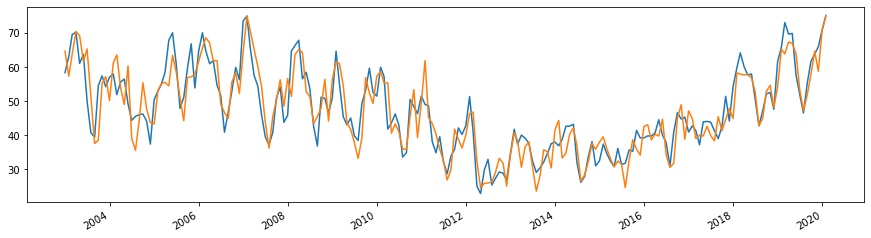

In [54]:
#Obtener mejor modelo de Arima
#Usamos como variables exógenas las sugeridas por random forest (No incluimos casos_covid porque no se puede predecir)
exogenas=ts_sin_COVID[['Plantilla']]
model10=auto_arima(ts_sin_COVID[['Plantilla_de_baja']],exog=exogenas, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model10.order 
sparams = model10.order+(12,) 
#freq MS quiere decir frecuencia mensual

smodel10 = SARIMAX(ts_sin_COVID[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

results10=smodel10.fit(maxiter=1000)

#intentamos hacer una prediccion de los datos  a partir de nuestro modelo
plt.plot(ts_sin_COVID['Plantilla_de_baja'])
y_pred_SAR10=results10.get_prediction(start='2003-01-01',end='2020-02-01').predicted_mean
y_pred_SAR10.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX=get_error_percentage(ts_sin_COVID[['Plantilla_de_baja']],y_pred_SAR10)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX}'


In [55]:
exogeno1=ts[['Plantilla']].reset_index().rename(columns={'date':'ds'}).set_index('ds')

In [56]:
ds= pd.DataFrame({'ds':pd.date_range(start='2022-03-01',
                                  end='2022-12-01',
                                  freq='MS')})
'''yhat_plantilla=pd.Series(modelo_plantilla_profet.predict(ds).yhat,
                         index=pd.date_range(start='2022-02-01',
                                  end='2022-12-01',
                                  freq='MS'))'''
yhat=model8.predict(ds).yhat
exogeno2=pd.DataFrame(data=yhat.to_numpy(),index=ds['ds'],columns=['Plantilla'])

In [57]:
exogeno=exogeno1.append(exogeno2)
exogeno=exogeno[-34:] #se añade los valores de la pandemia

<AxesSubplot:>

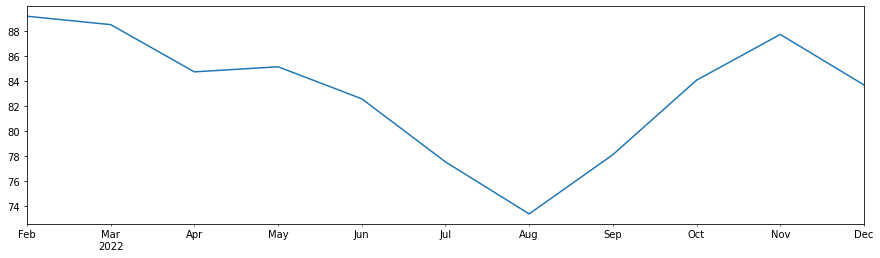

In [58]:
y_pred_inf=results10.get_prediction(start='2022-02-01',end='2022-12-01',exog=exogeno).predicted_mean
y_pred_inf.plot()

## Exportar modelos

Decidimos exportar el terce modelo con mejor score (smodel4) porque evita tener que predecir la variable exógena "casos_covid".

Para usar el modelo debemos exportar:
* Modelo ARIMA 
* Modelo Prophet para predecir variable exógena de Plantilla
* Modelo ARIMA para predecir variable de búsquedas google
* Dataset con datos históricos para entrenas modelos ARIMA

In [59]:
import pickle

In [60]:
#Exportamos el segundo mejor modelo porque éste no requiere predecir los casos covid
with open('models/model_enfermeras.pkl','wb') as f:
    pickle.dump(model4,f)

In [61]:
#Modelo Prophet para predecir variable exógena de Plantilla
with open('models/model_enfermeras_plantilla.pkl','wb') as f:
    pickle.dump(model8,f)

In [62]:
#Modelo Arima para predecir variable exógena de búsquedas_google
with open('models/model_enfermeras_google.pkl','wb') as f:
    pickle.dump(model10,f)

## Otros

In [63]:
#Exportamos el model sin tener en cuenta la pandemia
#with open('models/model_enfermeras_sin_covid.pkl','wb') as f:
#    pickle.dump(smodel10,f)

In [64]:
ts_it.tail(12) #las predicciones con pandemia me salen disparadas

,Plantilla_de_baja
date,
2021-03-01,77.846129
2021-04-01,77.978333
2021-05-01,68.478065
2021-06-01,67.994333
2021-07-01,73.054194
2021-08-01,62.301290
2021-09-01,59.239667
2021-10-01,65.073548
2021-11-01,65.600333


In [65]:
#Exportamos el tercer mejor modelo Arima porque éste no requiere predecir los casos covid sin entrenar
#with open('models/model_enfermeras2.pkl','wb') as f:
 #   pickle.dump(model3,f)

In [66]:
#Exportamos el tercer mejor modelo Arima porque éste no requiere predecir los casos covid sin entrenar
#with open('models/model_enfermeras3.pkl','wb') as f:
#    pickle.dump(model3b,f)